# Preprocessing Data for ToxicityPredictor

In [1]:
%pip install rdkit
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

In [3]:
CONFIG = {
    'dataset_path': './tox21.csv.gz',
    'output_dir': './processed_tox21',
    'test_size': 0.1,
    'validation_size': 0.1,
    'seed': 1
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)

In [4]:
df = pd.read_csv("tox21.csv.gz")
print(df.shape)
df.head()

(7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


Test to see visualization of molecules

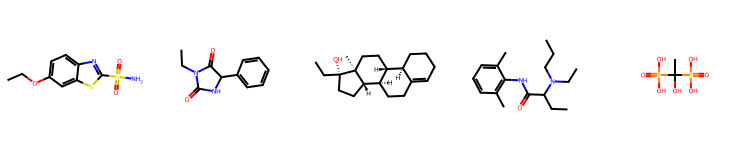

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in df['smiles'].head(5)]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(150,150))

Dataset Structure Analysis

In [6]:
print("Columns:", list(df.columns))
label_cols = [c for c in df.columns if c not in ['smiles', 'mol_id']]
print(f"Found {len(label_cols)} label columns:", label_cols)

Columns: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']
Found 12 label columns: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']


In [7]:
nan_ratio = df[label_cols].isna().mean().round(3)
print("Fraction of missing values per label:")
print(nan_ratio)

Fraction of missing values per label:
NR-AR            0.072
NR-AR-LBD        0.137
NR-AhR           0.164
NR-Aromatase     0.257
NR-ER            0.209
NR-ER-LBD        0.112
NR-PPAR-gamma    0.176
SR-ARE           0.255
SR-ATAD5         0.097
SR-HSE           0.174
SR-MMP           0.258
SR-p53           0.135
dtype: float64


Remove invalid molecules by validating SMILES

In [8]:
valid_smiles = []
valid_labels = []

for _, row in df.iterrows():
    smile = row['smiles']
    molecule = Chem.MolFromSmiles(smile)
    if molecule is None:
        continue # skips invalid molecule
    labels = row[label_cols].to_numpy(dtype=float)
    valid_smiles.append(smile)
    valid_labels.append(labels)

valid_smiles = np.array(valid_smiles)
valid_labels = np.vstack(valid_labels)
print(f"{len(valid_smiles)} valid molecules out of {len(df)}")

[11:31:43] WARNING: not removing hydrogen atom without neighbors
[11:31:43] Explicit valence for atom # 8 Al, 6, is greater than permitted
[11:31:44] Explicit valence for atom # 3 Al, 6, is greater than permitted
[11:31:44] Explicit valence for atom # 4 Al, 6, is greater than permitted
[11:31:44] Explicit valence for atom # 4 Al, 6, is greater than permitted
[11:31:44] Explicit valence for atom # 9 Al, 6, is greater than permitted
[11:31:44] Explicit valence for atom # 5 Al, 6, is greater than permitted
[11:31:45] Explicit valence for atom # 16 Al, 6, is greater than permitted
[11:31:45] Explicit valence for atom # 20 Al, 6, is greater than permitted


7823 valid molecules out of 7831


In [9]:
mask = ~np.all(np.isnan(valid_labels), axis=1)
valid_smiles = valid_smiles[mask]
valid_labels = valid_labels[mask]
print(f"{len(valid_smiles)} molecules left after removing unlabelled samples")

7823 molecules left after removing unlabelled samples


Creating stratified splits, so training, validation, and testing sets have the same ratio of toxic to non-toxic molecules

In [10]:
# This turns all NaN labels to 0
stratify_label = np.nan_to_num(valid_labels, nan=0).max(axis=1)

x_train, x_temp, y_train, y_temp = train_test_split(
    valid_smiles, valid_labels,
    test_size=CONFIG['validation_size'] + CONFIG['test_size'],
    stratify=stratify_label,
    random_state=CONFIG['seed']
)

rel_test_size = CONFIG['test_size'] / (CONFIG['validation_size'] + CONFIG['test_size'])
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size = rel_test_size,
    random_state = CONFIG['seed']
)

print(f"Train: {len(x_train)} | Validation: {len(x_val)} | Test: {len(x_test)}")

Train: 6258 | Validation: 782 | Test: 783


Save processed splits to file for usage

In [11]:
def save_split(name, smiles, labels):
    path = os.path.join(CONFIG['output_dir'], f'tox21_{name}.pkl')
    with open(path, 'wb') as f:
        pickle.dump({'smiles': smiles, 'labels': labels, 'labels_cols': label_cols}, f)
    print(f"Saved {name} split to path: {path}")

In [12]:
save_split('train', x_train, y_train)
save_split('validation', x_val, y_val)
save_split('test', x_test, y_test)

Saved train split to path: ./processed_tox21\tox21_train.pkl
Saved validation split to path: ./processed_tox21\tox21_validation.pkl
Saved test split to path: ./processed_tox21\tox21_test.pkl


Verifying saved data

In [13]:
example = pickle.load(open(os.path.join(CONFIG['output_dir'], 'tox21_train.pkl'), 'rb'))
print(f"Loaded {len(example['smiles'])} training molecules.")
print("Example SMILES:", example['smiles'][0])
print("Example labels:", example['labels'][0])

print(f"Loaded {len(example['smiles'])} validation molecules.")
print("Example SMILES:", example['smiles'][0])
print("Example labels:", example['labels'][0])

print(f"Loaded {len(example['smiles'])} testing molecules.")
print("Example SMILES:", example['smiles'][0])
print("Example labels:", example['labels'][0])

Loaded 6258 training molecules.
Example SMILES: COC(=O)[C@H]1CC[C@H](C(=O)OC)CC1
Example labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loaded 6258 validation molecules.
Example SMILES: COC(=O)[C@H]1CC[C@H](C(=O)OC)CC1
Example labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loaded 6258 testing molecules.
Example SMILES: COC(=O)[C@H]1CC[C@H](C(=O)OC)CC1
Example labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
